In [1]:
import cellbell
%pylab inline
import csv
import scipy as sp

Populating the interactive namespace from numpy and matplotlib


In [2]:
# inputValues = np.zeros(3)
inputValues = np.zeros(12)
outputValues = np.zeros(5)

recIndex = 0
isRecording = False
modelIsTrained = False

trainedIndices = [0,1,2,3]


perfIndex = 0
perfGestIndex = 0
perfStartIndex = 0
perfEndIndex = 0
runningIndex = 0

isPerforming = False

### gestures
gesture_indices = np.zeros( 50, dtype=np.object )
train_gestures = np.zeros(10, dtype=np.object)
newGesture = np.zeros(0)

runningGesture = np.zeros(0)

# print( shape(gestures ) )

params = {'N':500, 'NetSR':1.5, 'NetinpScaling':1.3,'BiasScaling':0.9,
         'washoutLength':200, 'learnLength':1200, 
          'LR': 0.2, 'connIn': 0.2, 'Nin': 12
#           'patts': gestures[[0,1,2,3]]
#           'patts':gestures[[0,1,2,3]]
         }


In [3]:
import dill as pickle

def save_data_to_file( data, tag ):
    ts = str(datetime.datetime.timestamp(datetime.datetime.now()))
    with open(r"patterns_chrysalis_" + tag + "_" + ts + ".pickled", "wb") as output_file:
        pickle.dump(data, output_file, protocol=0)



In [4]:
def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = abs(np.linalg.eig(internalWeights)[0][0])
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights

In [5]:
def makeClassifierNetwork(p):
    Netconnectivity = 1
    if p['N'] > 20:
        Netconnectivity = 10.0/p['N'];
    WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
    WinRaw = 2 * (np.random.rand(p['N'], p['Nin']) - 0.5) *  (np.random.random((p['N'],  p['Nin'])) < p['connIn'])
    WbiasRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)

    #Scale raw weights     
    Wstar = p['NetSR'] * WstarRaw;
    W = Wstar
    Win = p['NetinpScaling'] * WinRaw;
    Wbias = p['BiasScaling'] * WbiasRaw;  
    I = np.eye(p['N'])
    xCollector = np.zeros((p['N'], p['learnLength']))
    pCollector = np.zeros(( p['Nin'], p['learnLength']))
    x = np.zeros((p['N'],1))
    
    allTrainxArgs = np.zeros((p['N'] + 1, 0));
#     allTrainOldxArgs = np.zeros((p['N'], 0));
#     allTrainWtargets = np.zeros((p['N'], 0));
#     allTrainOuts = np.zeros(( p['Nin'], 0));
    patternRs =  np.zeros((1, p['patts'].size), dtype=np.object)
    
    for i_pattern in range(p['patts'].size):
        print('Observing pattern ', i_pattern)
        patt = p['patts'][i_pattern]
        xCollector = np.zeros((p['N'] + 1, p['learnLength']));
#         xOldCollector = np.zeros((p['N'], p['learnLength']));
#         WTargetCollector = np.zeros((p['N'], p['learnLength']));
#         pCollector = np.zeros(( p['Nin'], p['learnLength']));
        x = np.zeros((p['N'], 1));

        for n in range(p['washoutLength'] + p['learnLength']):
            u = patt.take(n, mode='wrap', axis=0)
            xOld = x
            Wtarget = (Wstar.dot(x)) + vstack(Win.dot(u))
            x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + Wbias))
            if n >= p['washoutLength']:
                xCollector[:, n - p['washoutLength']] = np.concatenate((x[:,0], np.array([1])))
#                 xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
#                 WTargetCollector[:, n - p['washoutLength']] = Wtarget[:,0]
#                 pCollector[:, n - p['washoutLength']] = u
#             uOld = u
        
        R = xCollector[0:-1].dot(xCollector[0:-1].T) / p['learnLength']
        patternRs[0,i_pattern] = R
        allTrainxArgs = np.concatenate((allTrainxArgs, xCollector), axis=1)
#         allTrainOldxArgs = np.concatenate((allTrainOldxArgs, xOldCollector), axis=1)
#         allTrainOuts = np.concatenate((allTrainOuts, pCollector), axis=1)
#         allTrainWtargets = np.concatenate((allTrainWtargets, WTargetCollector), axis=1)
        print("Done")

    return locals()


In [6]:
def computeConceptor(p, net, i_pattern, alpha):
#     print('Computing conceptor, alpha: ', alpha)
    Cs = np.zeros((4, 1), dtype=np.object)
    R = net['patternRs'][0,i_pattern]
    [U,s,V] = svd(R)
    S = diag(s)
    Snew = (S * linalg.inv(S + pow(alpha, -2) * np.eye(p['N'])))

    C =  U.dot(Snew).dot(U.conj().T);
    Cs[0,0] = C
    Cs[1,0] = U
    Cs[2,0] = diag(Snew)
    Cs[3,0] = diag(S)

    return Cs

def testConceptor(net, cNet, recallTestLength):
    trials = 1
    attens = np.zeros(trials)
    p = net['p']
    C = cNet[0,0]
    for i_trial in range(trials):
        x_CTestPL = np.zeros((p['N'], recallTestLength))
        z_CTestPL = np.zeros((p['N'], recallTestLength))
#         p_CTestPL = np.zeros((1, recallTestLength))
        x = 0.5 * np.random.randn(p['N'],1)
        z = x
        for n in range(recallTestLength + p['washoutLength']):
            xOld = x
            Wtarget = (net['W'].dot(x))
            z = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + net['Wbias']))
            x = C.dot(z)
            xPrev = x
            if (n > p['washoutLength']):
                x_CTestPL[:,n-p['washoutLength']] = x.T
                z_CTestPL[:,n-p['washoutLength']] = z.T
#                 p_CTestPL[:,n-p['washoutLength']] = cNet['net']['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))

#         attenuation = np.mean(pow(np.sum(z_CTestPL[:,:] - x_CTestPL[:,:], axis=1),2)) / np.mean(pow(np.sum(z_CTestPL[:,:], axis=1),2))
        attenuation = np.mean(pow(np.linalg.norm(z_CTestPL[:,:] - x_CTestPL[:,:], axis=1),2)) / np.mean(pow(np.linalg.norm(z_CTestPL[:,:], axis=1),2))
        attens[i_trial] = attenuation
        
    return np.mean(attens)

def fitnessf(aperture, *args):
    print('Pattern: ', args[0])
    cnet = computeConceptor(net['p'], net, args[0], aperture)
    atten = testConceptor(net, cnet, 300)
    return atten

In [7]:
import scipy.optimize

def calculate_apertures():
    apertures = [sp.optimize.fminbound(fitnessf, 0, 500,  disp=3, xtol=1, args = (x,)) 
             for x in np.arange(net['p']['patts'].shape[0])]
    return apertures

def calculate_conceptors( apertures ):
    #store conceptors with calculated apertures
    patternCs = np.zeros(len(apertures), dtype=np.object)
    for i_patt in range(patternCs.size):
        patternCs[i_patt] = computeConceptor(net['p'], net, i_patt, apertures[i_patt])
    cellbell.ding()
    return patternCs

In [8]:
import scipy.spatial.distance as dist

#calc negative evidence
def conceptorOr(C,B):
    I = np.eye(C.shape[0])
    return linalg.inv(I + linalg.inv(C.dot(linalg.inv(1.0-C)) + B.dot(linalg.inv(1.0-B))))


def plotConceptorPatterns(net, cNet, recallTestLength):
    patternCsNeg = np.zeros(len(apertures), dtype=np.object)

    for i_c in arange(net['p']['patts'].size):
        idxs = np.delete(arange(net['p']['patts'].size), i_c)
        Cneg = conceptorOr(patternCs[idxs[0]][0,0], patternCs[idxs[1]][0,0])
        for i_idx in idxs[2:]:
            Cneg = conceptorOr(Cneg, patternCs[i_idx][0,0])
        Cneg = 1.0 - Cneg
        patternCsNeg[i_c] = Cneg

#     x_CTestPL = np.zeros((3, recallTestLength, p['patts'].size))
#     p_CTestPL = np.zeros((1, recallTestLength, p['patts'].size))
    cx_CTestPL = np.zeros((net['p']['patts'].size+1,recallTestLength))
    pat_CTestPL = np.zeros((net['p']['Nin'],recallTestLength))
    
    CNone = conceptorOr(patternCs[0][0,0], patternCs[1][0,0])
    for i_idx in arange(net['p']['patts'].size)[2:]:
        CNone = conceptorOr(CNone, patternCs[i_idx][0,0])
    CNone = 1.0 - CNone
        
    for i_pattern in range(net['p']['patts'].size):
        patt = net['p']['patts'][i_pattern]
        x = np.zeros((net['p']['N'],1))
        for n in range(recallTestLength + net['p']['washoutLength']):
            u = patt.take(n, mode='wrap', axis=0)
            xOld = x
            Wtarget = (net['Wstar'].dot(x)) + vstack((net['Win'].dot(u)))
            x = ((1.0-net['p']['LR']) * xOld) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
            if (n > net['p']['washoutLength']):
                pat_CTestPL[:,n-net['p']['washoutLength'] ] = u
                
                for i_ev in range(net['p']['patts'].size):
                    C = patternCs[i_ev][0,0]
                    C2 = patternCsNeg[i_ev]
                    cx = x.T.dot(C.dot(x))
                    cx2 = x.T.dot(C2.dot(x))
                    cx_CTestPL[i_ev,n-net['p']['washoutLength']] = cx + cx2
                cxNone = x.T.dot(CNone.dot(x))
                cx_CTestPL[-1,n-net['p']['washoutLength']] = cxNone
                    

        ax = subplot(net['p']['patts'].size * 2, 2, i_pattern*2 + 1)
#         ax.set_title("Sample " + str(suboff/2) + ", pattern: " + str(i_pattern) )
#         plot([p['patts'][i_pattern](x) for x in arange(recallTestLength)])
        plot(pat_CTestPL.T)
        ax = subplot(net['p']['patts'].size * 2, 2, i_pattern*2 + 2)
#         for i_plot in range(net['p']['patts'].size):
#             plot(cx_CTestPL[i_plot,1:].T, label=i_plot, alpha=0.8)
            
        data = cx_CTestPL[0,1:].T * 3 - cx_CTestPL[1,1:].T - cx_CTestPL[2,1:].T - cx_CTestPL[3,1:].T
        plot(data, label=0, alpha=0.8)
        data = cx_CTestPL[1,1:].T * 3 - cx_CTestPL[0,1:].T - cx_CTestPL[2,1:].T - cx_CTestPL[3,1:].T
        plot(data, label=1, alpha=0.8)
        data = cx_CTestPL[2,1:].T * 3 - cx_CTestPL[0,1:].T - cx_CTestPL[1,1:].T - cx_CTestPL[3,1:].T
        plot(data, label=2, alpha=0.8)
        data = cx_CTestPL[3,1:].T * 3 - cx_CTestPL[0,1:].T - cx_CTestPL[1,1:].T - cx_CTestPL[2,1:].T
        plot(data, label=3, alpha=0.8)

            
        #plot(cx_CTestPL[-1,1:].T, label="None", alpha=0.8)
        ax.legend()
        classificationScore = np.sum(cx_CTestPL[i_pattern] ==  np.max(cx_CTestPL, axis=0)) / cx_CTestPL[0].size
        otherResponses = cx_CTestPL[[x for x in arange(net['p']['patts'].size) if x != i_pattern]]
        otherResponsesRange = dist.euclidean(np.max(otherResponses, axis=0),np.min(otherResponses, axis=0))
        separation = dist.euclidean(cx_CTestPL[i_pattern],np.max(otherResponses, axis=0)) / otherResponsesRange
        print("Pattern ", str(i_pattern), " classification score: ", classificationScore, ", separation: ", separation)
        #testing

    return locals()

def getAccuracyConceptorPatterns(net, cNet, recallTestLength):
    patternCsNeg = np.zeros(len(apertures), dtype=np.object)

    for i_c in arange(net['p']['patts'].size):
        idxs = np.delete(arange(net['p']['patts'].size), i_c)
        Cneg = conceptorOr(patternCs[idxs[0]][0,0], patternCs[idxs[1]][0,0])
        for i_idx in idxs[2:]:
            Cneg = conceptorOr(Cneg, patternCs[i_idx][0,0])
        Cneg = 1.0 - Cneg
        patternCsNeg[i_c] = Cneg

#     x_CTestPL = np.zeros((3, recallTestLength, p['patts'].size))
#     p_CTestPL = np.zeros((1, recallTestLength, p['patts'].size))
    cx_CTestPL = np.zeros((net['p']['patts'].size+1,recallTestLength))
    pat_CTestPL = np.zeros((net['p']['Nin'],recallTestLength))
    
    CNone = conceptorOr(patternCs[0][0,0], patternCs[1][0,0])
    for i_idx in arange(net['p']['patts'].size)[2:]:
        CNone = conceptorOr(CNone, patternCs[i_idx][0,0])
    CNone = 1.0 - CNone
    
    classificationScores = np.zeros( net['p']['patts'].size )
    separations = np.zeros( net['p']['patts'].size )
    
    for i_pattern in range(net['p']['patts'].size):
        patt = net['p']['patts'][i_pattern]
        x = np.zeros((net['p']['N'],1))
        for n in range(recallTestLength + net['p']['washoutLength']):
            u = patt.take(n, mode='wrap', axis=0)
            xOld = x
            Wtarget = (net['Wstar'].dot(x)) + vstack((net['Win'].dot(u)))
            x = ((1.0-net['p']['LR']) * xOld) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
            if (n > net['p']['washoutLength']):
                pat_CTestPL[:,n-net['p']['washoutLength'] ] = u
                
                for i_ev in range(net['p']['patts'].size):
                    C = patternCs[i_ev][0,0]
                    C2 = patternCsNeg[i_ev]
                    cx = x.T.dot(C.dot(x))
                    cx2 = x.T.dot(C2.dot(x))
                    cx_CTestPL[i_ev,n-net['p']['washoutLength']] = cx + cx2
                cxNone = x.T.dot(CNone.dot(x))
                cx_CTestPL[-1,n-net['p']['washoutLength']] = cxNone
                    

        classificationScores[i_pattern] = np.sum(cx_CTestPL[i_pattern] ==  np.max(cx_CTestPL, axis=0)) / cx_CTestPL[0].size
        otherResponses = cx_CTestPL[[x for x in arange(net['p']['patts'].size) if x != i_pattern]]
        otherResponsesRange = dist.euclidean(np.max(otherResponses, axis=0),np.min(otherResponses, axis=0))
        separations[i_pattern] = dist.euclidean(cx_CTestPL[i_pattern],np.max(otherResponses, axis=0)) / otherResponsesRange
        print("Pattern ", str(i_pattern), " classification score: ", classificationScores[i_pattern], ", separation: ", separations[i_pattern])

    return locals()


In [9]:
#runtime

def generateClassificationConceptors(net, cNet):
    #calc negative evidence
    def conceptorOr(C,B):
        I = np.eye(C.shape[0])
        return linalg.inv(I + linalg.inv(C.dot(linalg.inv(1.0-C)) + B.dot(linalg.inv(1.0-B))))
    patternCsNeg = np.zeros(len(apertures), dtype=np.object)

    for i_c in arange(net['p']['patts'].size):
        idxs = np.delete(arange(net['p']['patts'].size), i_c)
        Cneg = conceptorOr(patternCs[idxs[0]][0,0], patternCs[idxs[1]][0,0])
        for i_idx in idxs[2:]:
            Cneg = conceptorOr(Cneg, patternCs[i_idx][0,0])
        Cneg = 1.0 - Cneg
        patternCsNeg[i_c] = Cneg

    CNone = conceptorOr(patternCs[0][0,0], patternCs[1][0,0])
    for i_idx in arange(net['p']['patts'].size)[2:]:
        CNone = conceptorOr(CNone, patternCs[i_idx][0,0])
    CNone = 1.0 - CNone
    
    return {'negatives':patternCsNeg, 'none':CNone}

def iterate(net, Cs, classifierCs, u):
    result = np.zeros(net['p']['patts'].size+1)
    net['xOld'] = net['x']
    Wtarget = (net['Wstar'].dot(net['x'])) + vstack((net['Win'].dot(u)))
#     print( Wtarget.shape )
    net['x'] = ((1.0-net['p']['LR']) * net['xOld']) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
    for i_ev in range(net['p']['patts'].size):
        C = Cs[i_ev][0,0]
        C2 = classifierCs['negatives'][i_ev]
        cx = net['x'].T.dot(C.dot(net['x']))
        cx2 = net['x'].T.dot(C2.dot(net['x']))
        result[i_ev] = cx + cx2
#         result[i_ev] = cx
    cxNone = net['x'].T.dot(classifierCs['none'].dot(net['x']))
#     net['xGest1'] = Cs[0][0,0].dot(net['x'])
    result[-1] = cxNone
    return result


In [10]:

# net = makeClassifierNetwork(params)
# print("Made classifier network")
# cellbell.ding()

# patternCs = calculate_apertures_and_conceptors()
# print("Calculated apertures and conceptors")
# cellbell.ding()

# ## before runtime
# net['x'] = np.zeros((net['p']['N'],1))
# classifierConceptors = generateClassificationConceptors(net, patternCs)
# print("Generated classifier conceptors")
# cellbell.ding()


In [11]:
import dill as pickle

def loadObject(filename):
    with open(filename, "rb") as input_file:
        restored = pickle.load(input_file)
    return restored

train_gestures = loadObject( "patterns_chrysalis_train_1515694755.32663.pickled" )

In [ ]:
## load the functions for receiving and sending osc
%run ../python/oscserver.py

def onTrainModel( indices ):
    global params, net, patternCs, apertures, trainedIndices
    save_data_to_file( train_gestures, "train" )
    print( "training model with gestures", indices )
    params['patts'] = train_gestures[ indices ]
    oscserver.send_value( "/model/trained", 0 )
    
    net = makeClassifierNetwork(params)
    print("Made classifier network")
    cellbell.ding()
    oscserver.send_value( "/model/trained", 1 )
    
#     figsize(20,10)
#     plot(net['allTrainxArgs'].T[:])
#     cellbell.ding()

    apertures = calculate_apertures()
    patternCs = calculate_conceptors(apertures)
    print("Calculated apertures and conceptors")
    cellbell.ding()
    oscserver.send_value( "/model/trained", 2 )
        
    quality = getAccuracyConceptorPatterns(net, patternCs, 100)
    oscserver.send_array( "/model/separation", quality['separations'] )
    oscserver.send_array( "/model/classificationScore", quality['classificationScores'] )
    cellbell.ding()
    
    oscserver.send_value( "/model/trained", 3 )
    trainedIndices = indices
    return True

def onStartModel():
    global classifierConceptors, modelIsTrained
    ## before runtime
    net['x'] = np.zeros((net['p']['N'],1))
    classifierConceptors = generateClassificationConceptors(net, patternCs)
    print("Generated classifier conceptors")
    modelIsTrained = True
    cellbell.ding()
    save_data_to_file( {"net":net, "Cs":classifierConceptors}, "model" )
    oscserver.send_value( "/model/started", 1 )
    return True

def onPerformOn( ind ):
    global perfIndex, perfStartIndex
    perfIndex = ind
    perfStartIndex = runningIndex
    print( "started performing", perfIndex, "start", perfStartIndex )
    return True

def onPerformOff():
    global perfIndex, perfStartIndex, perfEndIndex, perfGestIndex
    perfEndIndex = runningIndex
    gesture_indices[ perfGestIndex ] = [ perfIndex, perfStartIndex, perfEndIndex, trainedIndices ]
    print( "stopped performing", perfIndex, "start", perfStartIndex, "end", perfEndIndex )
    save_data_to_file( gesture_indices, "gesture_indices" )
    save_data_to_file( runningGesture, "runningGesture" )
    perfGestIndex = (perfGestIndex + 1)%50
    perfIndex = -1
    return True


def onRecordOn( ind ):
    global recIndex, isRecording, newGesture, modelIsTrained
    modelIsTrained = False
    recIndex = ind
    isRecording = True
    newGesture = np.zeros(0)
    print( "started recording", recIndex )
    return True

def onRecordOff():
    global isRecording, newGesture, train_gestures
    isRecording = False
    newGesture = newGesture.reshape( int( newGesture.shape[0]/len(inputValues)),len(inputValues))
    train_gestures[ recIndex ] = newGesture
    print( "stopped recording", recIndex, shape( newGesture ) )
    return True

def onAccelero(args):
    global inputValues, newGesture, newOutput, outputValues, runningGesture, runningIndex
#     print( args )
    inputValues = args
    if isRecording:
        newGesture = np.append( newGesture, inputValues )
    if modelIsTrained:
        output = iterate(net, patternCs, classifierConceptors, inputValues)
        outputValues = output
        oscserver.send_array( "/output", output )
        runningGesture = np.append( runningGesture, np.concatenate( ( [runningIndex, perfIndex], inputValues, outputValues, trainedIndices ) ) )
        runningIndex = runningIndex + 1
    return True

def onExit():
    print( "exiting" )
    global keepRunning
    keepRunning = False
    oscserver.free()
    return True

oscserver = makeOSCServer(57120, 57402, onExit)
oscserver.onAccelero = onAccelero
oscserver.onRecordOff = onRecordOff
oscserver.onRecordOn = onRecordOn
oscserver.onPerformOff = onPerformOff
oscserver.onPerformOn = onPerformOn
oscserver.onTrainModel = onTrainModel
oscserver.onStartModel = onStartModel

oscserver.start()

In [ ]:
k = runningGesture.reshape(int(runningGesture.shape[0]/23),23)

In [ ]:
outputValues.shape[0] + len(inputValues) + len(trainedIndices) + 2

In [ ]:
figsize(20,10)
ax = plot(k[40000:,14:18])


In [ ]:
gesture_indices

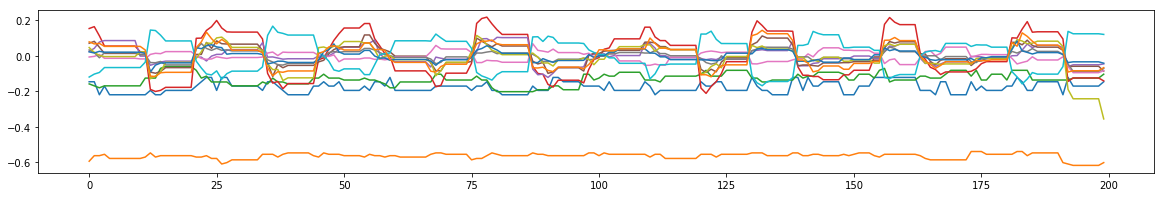

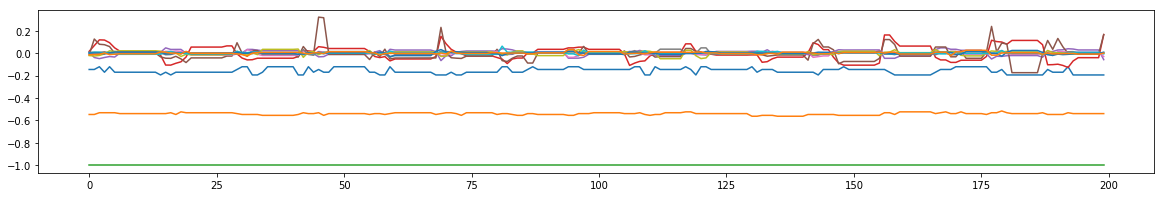

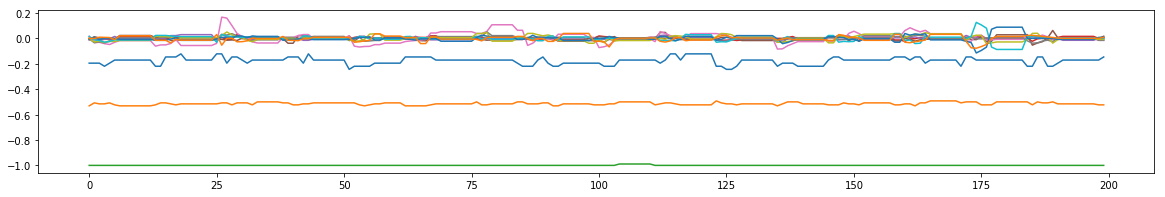

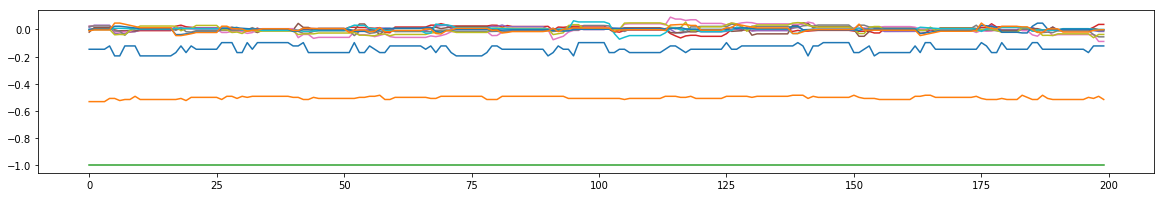

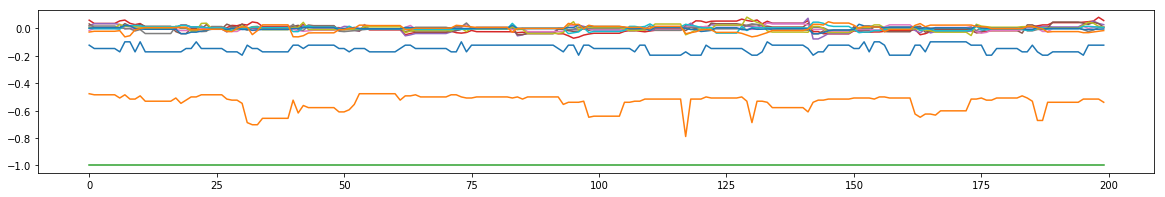

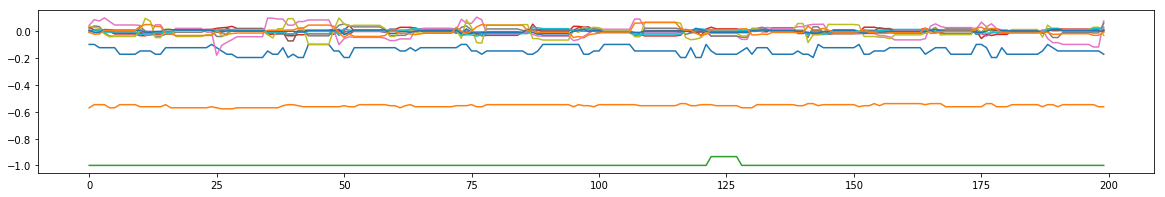

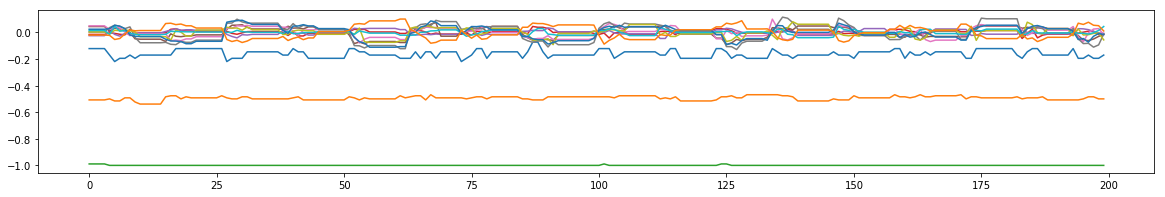

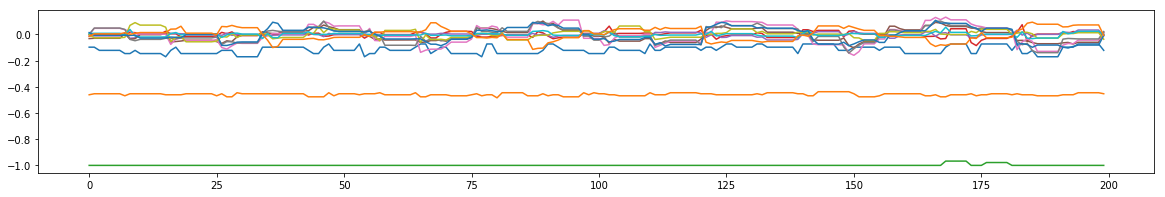

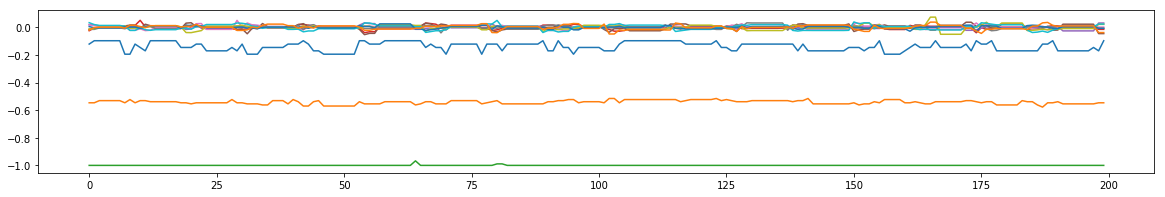

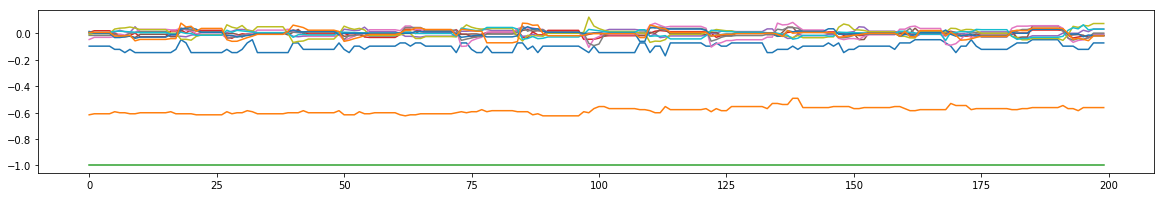

In [12]:

figsize(20,3)

for i in arange(train_gestures.shape[0]):
    figure(i)
    plot(train_gestures[i])